# Example (3) ニュース記事の分類 (multi-class classification)

- 基本的に，["Deep Learning with Python"](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438/)のSection 3.5(78-84ページ)を元にしている．  
- [原本のコード](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.6-classifying-newswires.ipynb)も入手可能であるが，それを解説を兼ねて多少改編している．  

## (1) Prepare dataset: The Reuters dataset

- Data format: [N,?]
- Training set: 8982 text sequences with multi(46)-classes label
- Test set: 2246 text sequences with multi(46)-classes label
- テキストの長さはそれぞれ異なるので，特定できない  

In [1]:
## reuters dataset is embedded in Keras framework, but it is pickled.
from keras.datasets import reuters

# modify the default parameters of np.load
import numpy as np
from pkg_resources import parse_version

## we need small modification to handle old-pickled data
np_pickle = parse_version(np.__version__) < parse_version('1.17.0')
if np_pickle:
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

if np_pickle:
    np.load = np_load_old

Using TensorFlow backend.


In [2]:
print(len(train_data))
print(len(test_data))
print(train_data[10])
print(train_labels[10])

8982
2246
[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]
3


In [3]:
## conversion from label to English word
word_index = reuters.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join(
    [reverse_word_index.get(i-3, '?') for i in train_data[0]]) ## 0:padding / 1:start / 2:unknown
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


## (2) Data conversion for training

- convert word sequence as 10,000 quantized vector.  
  it is similar to IMDB dataset
- convert results data from 

In [4]:
## for x (text sequence): similar to IMDB dataset conversion ...
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test  = vectorize_sequences(test_data)

In [5]:
## for y: one hot vector
'''
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels  = to_one_hot(test_labels)
'''

## by keras' built-in function
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels  = to_categorical(test_labels)

print(one_hot_train_labels[10])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## (3) Prepare model

- Fully connectedで(隠し2層)単純なネットワークを構成する  
- 識別問題(multi-class classification)なので，訓練のloss関数としてcrossentropyを用いる  

In [6]:
from keras import models
from keras import layers

## build model (fully-connected layer)
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) ## softmax is better for multi-classes
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## (4) Training & testing neural network

### (4-i) Training model

In [7]:
## separating data for validation (0~999) / training (1000~)
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [8]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 130us/step - loss: 2.4475 - accuracy: 0.5445 - val_loss: 1.6107 - val_accuracy: 0.6610
Epoch 2/20
7982/7982 [==============================] - 1s 82us/step - loss: 1.3272 - accuracy: 0.7175 - val_loss: 1.2679 - val_accuracy: 0.7090
Epoch 3/20
7982/7982 [==============================] - 1s 82us/step - loss: 1.0014 - accuracy: 0.7783 - val_loss: 1.1120 - val_accuracy: 0.7500
Epoch 4/20
7982/7982 [==============================] - 1s 81us/step - loss: 0.7871 - accuracy: 0.8286 - val_loss: 1.0224 - val_accuracy: 0.7740
Epoch 5/20
7982/7982 [==============================] - 1s 81us/step - loss: 0.6271 - accuracy: 0.8647 - val_loss: 0.9519 - val_accuracy: 0.8080
Epoch 6/20
7982/7982 [==============================] - 1s 81us/step - loss: 0.5000 - accuracy: 0.8958 - val_loss: 0.9300 - val_accuracy: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 83us/step - loss: 0.40

### (4-ii) Visualizing the Training Progress

- 訓練課程はmodel.fit()の既に出力として保存されている  
- その訓練課程をmatplotlibで可視化する  

In [9]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


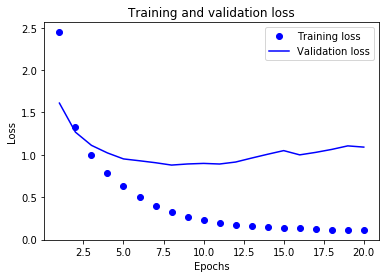

In [10]:
import matplotlib.pyplot as plt

loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss    , 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b' , label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

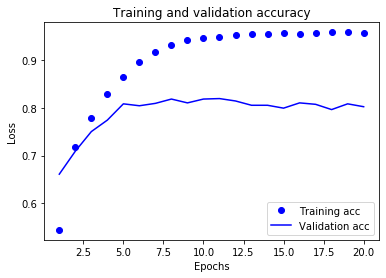

In [11]:
plt.clf() ## clear the figure

acc     = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc    , 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b' , label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Miscellaneous (1) small epochs

In [12]:
## another (but the same structured) model
model2 = models.Sequential()
model2.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(46, activation='softmax'))

model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

## training another model with relatively small epochs
model2.fit(partial_x_train,
           partial_y_train,
           epochs=9,
           batch_size=512,
           validation_data=(x_val, y_val))

## accuracy reaches ~80%
results = model2.evaluate(x_test, one_hot_test_labels)
print(results)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 89us/step - loss: 2.7520 - accuracy: 0.5013 - val_loss: 1.8531 - val_accuracy: 0.6140
Epoch 2/9
7982/7982 [==============================] - 1s 81us/step - loss: 1.4906 - accuracy: 0.6978 - val_loss: 1.3458 - val_accuracy: 0.7190
Epoch 3/9
7982/7982 [==============================] - 1s 81us/step - loss: 1.0865 - accuracy: 0.7711 - val_loss: 1.1520 - val_accuracy: 0.7540
Epoch 4/9
7982/7982 [==============================] - 1s 82us/step - loss: 0.8540 - accuracy: 0.8245 - val_loss: 1.0505 - val_accuracy: 0.7830
Epoch 5/9
7982/7982 [==============================] - 1s 82us/step - loss: 0.6813 - accuracy: 0.8608 - val_loss: 0.9841 - val_accuracy: 0.8030
Epoch 6/9
7982/7982 [==============================] - 1s 81us/step - loss: 0.5456 - accuracy: 0.8895 - val_loss: 0.9402 - val_accuracy: 0.8060
Epoch 7/9
7982/7982 [==============================] - 1s 81us/step - loss: 0.4362 - acc

In [13]:
predictions = model.predict(x_test)

print(predictions[0].shape)      ## 46 categories
print(predictions[0])            ## list of predicted probability
print(np.sum(predictions[0]))    ## should be 1.0
print(np.argmax(predictions[0])) ## largest entry = predicted class

(46,)
[1.1104627e-07 8.4566727e-07 6.8198140e-08 9.5271564e-01 4.5067757e-02
 2.8388590e-07 1.0629191e-06 2.9637274e-06 2.9609026e-04 6.9456933e-06
 1.2729971e-06 5.7825114e-04 5.5580649e-08 5.4360869e-05 2.4776131e-07
 9.6212494e-10 4.7051159e-05 7.2814157e-07 1.0959880e-07 4.0497401e-04
 6.2434806e-04 5.9795937e-05 3.1776855e-07 6.8520287e-09 7.2282963e-10
 1.9981517e-08 2.2647985e-08 3.0351026e-07 3.4980422e-07 2.9869110e-05
 2.5935889e-05 1.1238548e-07 4.4449294e-08 1.3236887e-06 1.0961824e-05
 1.2597816e-07 5.5474768e-05 6.4103510e-08 1.5559877e-07 1.0248627e-05
 8.1397252e-07 6.8465289e-07 1.5514284e-09 5.4761234e-08 5.1701653e-11
 9.9291512e-08]
0.99999994
3


In [14]:
print(x_test[0])

[0. 1. 1. ... 0. 0. 0.]


## Miscellaneous (2) A model with an information bottleneck

In [15]:
y_train = np.array(train_labels)
y_test  = np.array(test_labels)

## a model with an information bottleneck
model3 = models.Sequential()
model3.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model3.add(layers.Dense( 4, activation='relu')) ## here is the BOTTLENECK
model3.add(layers.Dense(46, activation='softmax'))

model3.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
model3.fit(partial_x_train,
           partial_y_train,
           epochs=20,
           batch_size=128,
           validation_data=(x_val, y_val))

## accuracy cannot exceed ~70%
results = model3.evaluate(x_test, one_hot_test_labels)
print(results)

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 104us/step - loss: 3.2722 - acc: 0.1845 - val_loss: 2.6789 - val_acc: 0.4010
Epoch 2/20
7982/7982 [==============================] - 1s 97us/step - loss: 2.1390 - acc: 0.5655 - val_loss: 1.8092 - val_acc: 0.6000
Epoch 3/20
7982/7982 [==============================] - 1s 96us/step - loss: 1.6075 - acc: 0.6139 - val_loss: 1.6205 - val_acc: 0.6130
Epoch 4/20
7982/7982 [==============================] - 1s 96us/step - loss: 1.4314 - acc: 0.6448 - val_loss: 1.5438 - val_acc: 0.6350
Epoch 5/20
7982/7982 [==============================] - 1s 95us/step - loss: 1.3148 - acc: 0.6620 - val_loss: 1.4909 - val_acc: 0.6300
Epoch 6/20
7982/7982 [==============================] - 1s 97us/step - loss: 1.2109 - acc: 0.6835 - val_loss: 1.4737 - val_acc: 0.6520
Epoch 7/20
7982/7982 [==============================] - 1s 96us/step - loss: 1.1160 - acc: 0.7098 - val_loss: 1.4297 - val_acc: 0.6550
Epoch 

(end)